# Analyzing @netanyahu Tweets Using Time Series & NLP Techniques 

**By Ori Rosenthal**<br> 
[LinkedIn](https://www.linkedin.com/in/ori-rosenthal-395bb859/) :
[Website](https://orosenthal.pythonanywhere.com/)
<img src="tweet_logo.png" alt="Drawing" style="width: 150px;"/>

This is a summary notebook of a more comprehensive study I conducted on Prime Minister Benjamin Netanyahu's tweets.  
You can see more analytics, code, visualization, and other features in the main notebook at the following link **[Link](https://nbviewer.jupyter.org/github/Orosenthal/PM-tweets-analysis/blob/main/PM%20tweets%20analysis.ipynb)

**In Israel, four rounds of Knesset elections have been held in the last two years.  
Social media is one of the primary channels by which the Prime Minister communicates with the general public.<br><br>Benjamin Netanyahu has approximately 1.8 million Twitter followers.<br><br>The primary aim of the research was to look for behavioral patterns and trends in the prime minister's tweets during the time before the elections.  Examine the number of tweets, the emotional content of them, and the topics on which the prime minister tweets.**

## Table of Contents:

1. <a href="#1.-General-Overview">General Overview</a>
2. <a href="#2.-Tweets-Frequency-vs.-Elections">Tweets Frequency vs. Elections</a>
3. <a href="#3.-Most-Common-Phrases">Most common Phrases</a>
4. <a href="#4.-Elections-Word-Cloud-&-Word2vec">Elections Word Cloud & Word2vec</a>
5. <a href="#5.-Words-Timeline-Occurrences">Words Timeline Occurrences</a>
6. <a href="#6.-Sentiment-Analysis-with-HeBERT">Sentiment Analysis with HeBERT</a>
7. <a href="#7.-Topic-Modeling">Topic-Modeling</a>
8. <a href="#8.-Topics-&-Sentiment">Topics & Sentiment</a>
9. <a href="#9.-Conclusion">Conclusion</a>



---

In [1]:
# Import packages
import pandas as pd
import numpy as np
import datetime as dt
from wordcloud import WordCloud
from bidi.algorithm import get_display
from sklearn.feature_extraction.text import CountVectorizer
from nltk.probability import FreqDist
from gsdmm import MovieGroupProcess
from gensim.models import Word2Vec
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
from  matplotlib.ticker import PercentFormatter
import matplotlib.patheffects as path_effects
from IPython.core.display import display
import seaborn as sns
import warnings
from pmUtils import gi_plot, most_common, sentiment_plot, sentiment_days
from pmUtils import sentiment_all, sentiment_dist_plot,monthly_count_plot, sentiment_m_time
warnings.filterwarnings("ignore")

%matplotlib inline

## 1. General Overview

In [2]:
# load preprocessed data (All the preprocessing can be seen in the main notebook, which can be accessed via the link above.)
df_main = pd.read_pickle('df_pm.pkl')
df = df_main[df_main.language =='iw'].copy() # only Hebrew tweets

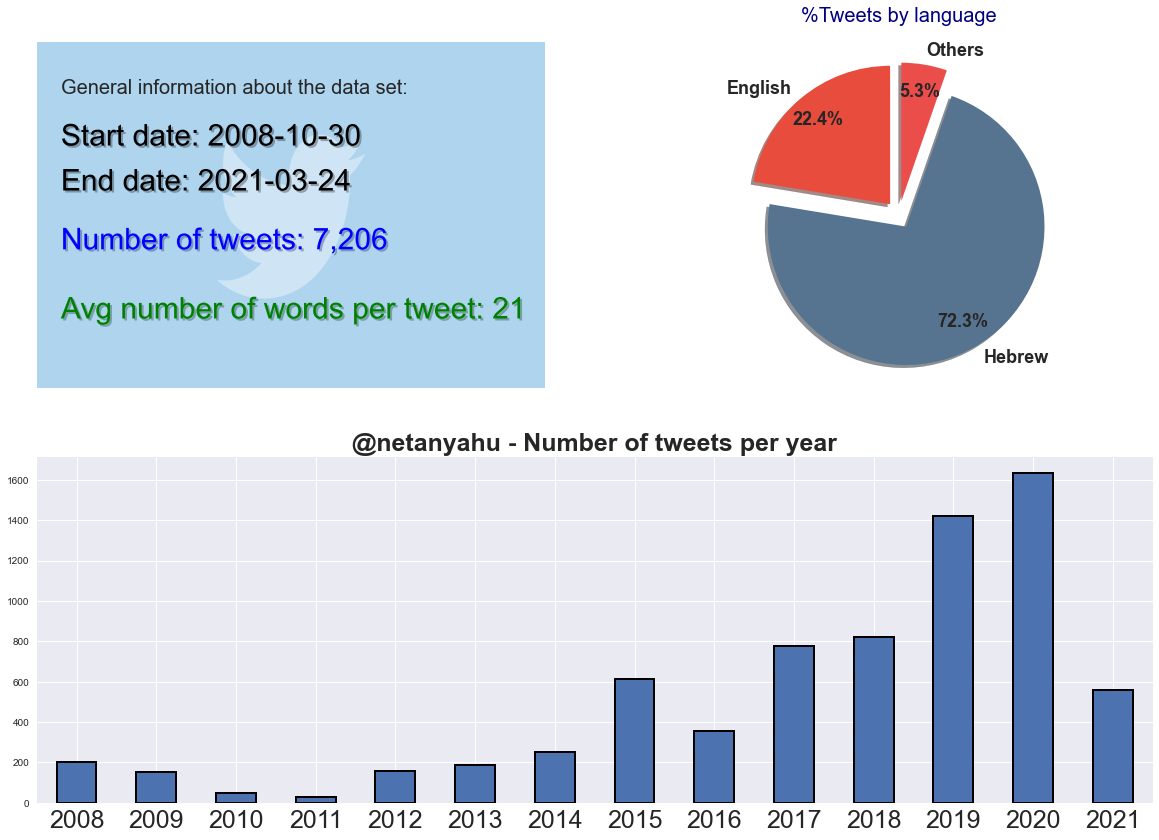

In [3]:
# Information about the datasets:
gi_plot(df_main)


* **The research was limited to Benjamin Netanyahu's <span style="background-color:Yellow"><u>Hebrew</u></span> tweets ,<br>which account for approximately 72 percent of all his tweets.**


* **Between 2010 and 2015, Twitter's global user base grew sixfold and has been relatively steady since then.<br>This statistic is important because it influences the usage pattern in Israel.<br>It also explains why Benjamin Netanyahu has been more involved on Twitter as a means of communicating with the general public.<br> In this case, the majority of the review would concentrate on the five elections that have occurred since then (from 2015 to the present).**

[<a href="#Table-of-Contents:">Back to top</a>]

## 2. Tweets Frequency vs. Elections

**<u>Calculate rolling sum of daily tweets</u>** 

As a way of measuring the trend in number of tweets before the general elections, I chose to first gather the number of tweets by day and then calculate the sum over a moving window (in this case 90 days). 
I've also included the elections dates (red verticals lines).







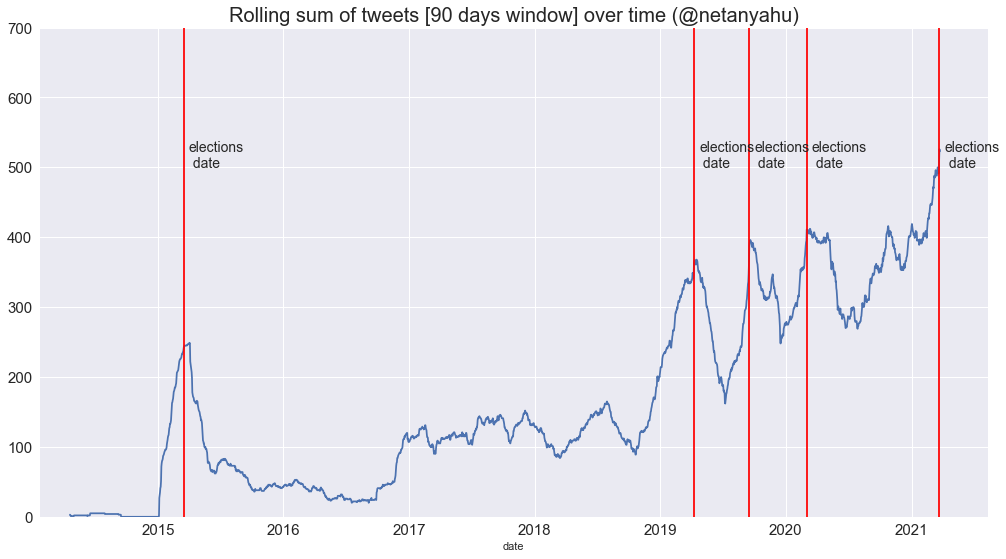

In [4]:
election_dates = ['2015-03-17', '2019-04-09', '2019-09-17', '2020-03-02','2021-03-23']

plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(17,9))
df['2014':].resample('D')['tweet'].count().rolling(90).sum().plot(figsize=(17,9),y="");plt.xticks(size=15);plt.yticks(size=15);
plt.title("Rolling sum of tweets [90 days window] over time (@netanyahu)",size=20);ax.set_xlim(16091 ,18850);ax.set_ylim(0 ,700)
for d in election_dates:
    plt.axvline(dt.datetime.fromisoformat(d), color='r')
    plt.text(dt.datetime.fromisoformat(d)+dt.timedelta(15),500,f'elections\n date',size=14)


**The number of tweets rises dramatically before each elections day, and fall afterward.**

Calculate the total number of tweets per month in the three months (90 days) leading up to each elections,  
and compare to the average number of tweets per month when there are no elections ahead.

The average number of tweets per month during the three months (90 days) preceding the election of 2015-03-17:  81
The average number of tweets per month during the three months (90 days) preceding the election of 2019-04-09:  121
The average number of tweets per month during the three months (90 days) preceding the election of 2019-09-17:  130
The average number of tweets per month during the three months (90 days) preceding the election of 2020-03-02:  137
The average number of tweets per month during the three months (90 days) preceding the election of 2021-03-23:  178

In times when there were no planned elections (from 2015-04 to 2018-12), the total number of tweets per month was: 32


Elections dates: ['2015-03-17', '2019-04-09', '2019-09-17', '2020-03-02', '2021-03-23']


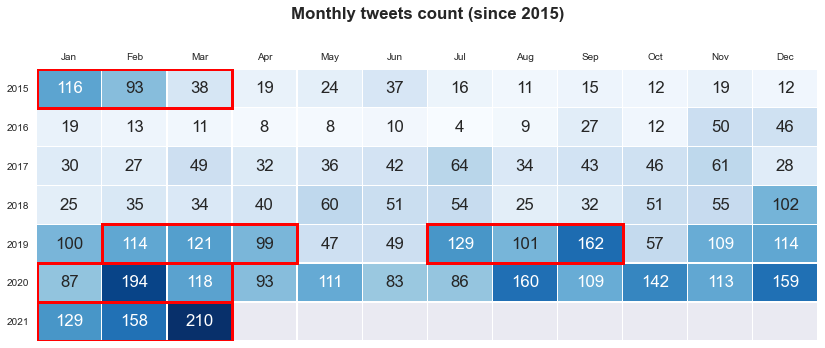

In [5]:
# calculating tweets by monthly agg. 
# Using the previous five voting dates (4 in the last two years and one before in 2015)
three_month_bfore_election =[str(dt.datetime.fromisoformat(i).date() - dt.timedelta(days=90)) for i in election_dates]
time_range_b4_elections = list(zip(three_month_bfore_election,election_dates))
for i in time_range_b4_elections:
    print(f"The average number of tweets per month during the three months (90 days) preceding the election of {i[1]}: "\
          ,round(df[i[0]:i[1]].tweet.count()/3))
print("")
print("In times when there were no planned elections (from 2015-04 to 2018-12), the total number of tweets per month was:",
      round(df['2015-04':'2018-12-31'].groupby(pd.Grouper(freq='M'))['tweet'].count().mean()))
print("\n\n" + "Elections dates:",election_dates)
monthly_count_plot(df)

The heat map shows the increase in the number of tweets per month, which begins several months before each general elections.  
It can also be seen that since the March 2020 elections, the number of tweets per month has remained high, probably in light of the corona plague that occurred during this period and the Israel–United Arab Emirates normalization agreement.

**And finaly let's see if the election dates are among the most tweeted dates by @netanyahu.**

Elections Dates:  ['2015-03-17', '2019-04-09', '2019-09-17', '2020-03-02', '2021-03-23']


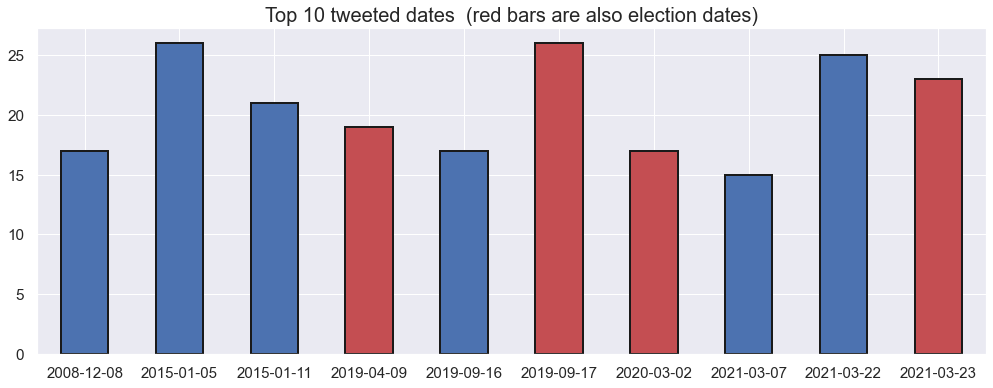

In [6]:
print('Elections Dates: ' ,election_dates)

top_dates = df.date.index.strftime('%Y-%m-%d').value_counts().head(10).to_frame('tweets_count').sort_index()
top_dates.tweets_count.plot(kind='bar',edgecolor='k',lw=2,figsize=(17,6),
                            color=['r' if x in(election_dates) else 'b'for x in top_dates.index])     
plt.title("Top 10 tweeted dates  (red bars are also election dates)", size=20); plt.xticks(size=15,rotation=0);

**As can be seen, four out of the five election days are also among the <u>top tweeted dates</u>.**

[<a href="#Table-of-Contents:">Back to top</a>]

## 3. Most Common Phrases

Let's start with trigrams for the whole corpus, then move on to bigrams in the three months leading up to each of 2019-2021 elections.  
**N-gram** is simply a sequence of N words. In addition, I developed an algorithm for removing duplicates of unigrams within bigrams and bigrams within trigrams.

In [7]:
df_tm = pd.read_pickle('df_tm.pkl')

# importing Hebrew stop words.
with open('he_stop_words.txt', "r") as f:
    he_s_words = f.readline().split(',')
he_s_words = [i.strip() for i in he_s_words]

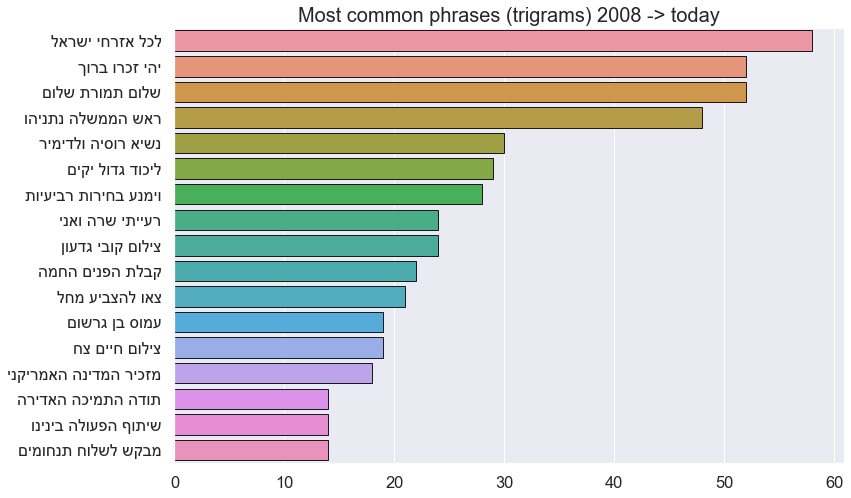

In [33]:
# Trigrams after moving stop words.
most_common(data=df_tm, sw = he_s_words, ngram=3)

### What were the most commonly used phrases in Netanyahu's tweets in the three months preceding each elections?

**Bigrams**       (for each elections)

* The percentage (X-axis), represents the percentage of tweets where the bigram appears out of the total number of tweets during that period.

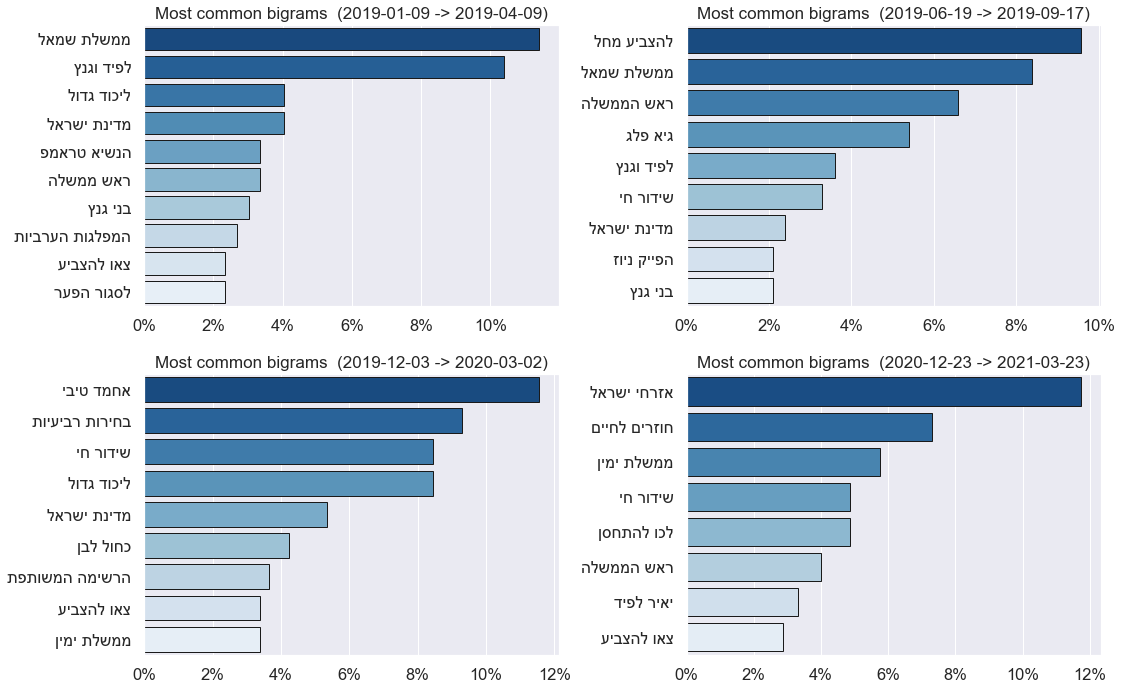

In [9]:
# Bigrams after moving stop words 
most_common(data=df_tm, sw = he_s_words, ngram=2)

[<a href="#Table-of-Contents:">Back to top</a>]

## 4. Elections Word Cloud & Word2vec
* (Word Cloud - text data visualization. Displays a list of words with varying sizes to reflect their significance).

### What were the most commonly used words in Netanyahu's tweets in the three months preceding each elections?

I will take out the words that are repeated most often in the data set, in order to see the words that are more characteristic of each elections campaign.

In [10]:
# finding top words (lemmas) in all tweets 
flat_words = [item for sublist in df_tm['lemma_text'] for item in sublist]
word_freq = FreqDist(flat_words).most_common(20)
# eliminate words that repeats themselves over 500 times
words_to_extract = [word[0] for word in word_freq if word[1] >500] 
print(word_freq)

[('ישראל', 2247), ('כול', 1314), ('ממשלה', 1067), ('מדינה', 925), ('ראש', 553), ('אזרח', 511), ('המשיך', 474), ('יום', 435), ('שלום', 430), ('ליכוד', 412), ('עולם', 401), ('שנה', 373), ('ביטחון', 322), ('נשיא', 320), ('רב', 317), ('קורונה', 317), ('יחד', 308), ('גדול', 291), ('בן', 289), ('חיים', 288)]


In [11]:
def word_cloud(text):
    
    twitter_mask = imageio.imread('./twitter_mask.png')
    wordcloud = WordCloud(width=800, height=500, stopwords = he_s_words,
                          font_path = 'C:\Windows\Fonts\courbd.ttf',random_state=10,
                          background_color='whitesmoke',max_words=50,contour_color='blue',
                          colormap='ocean',collocations=False, contour_width=0.15,
                          min_font_size= 10).generate(get_display(text))
    
    return wordcloud

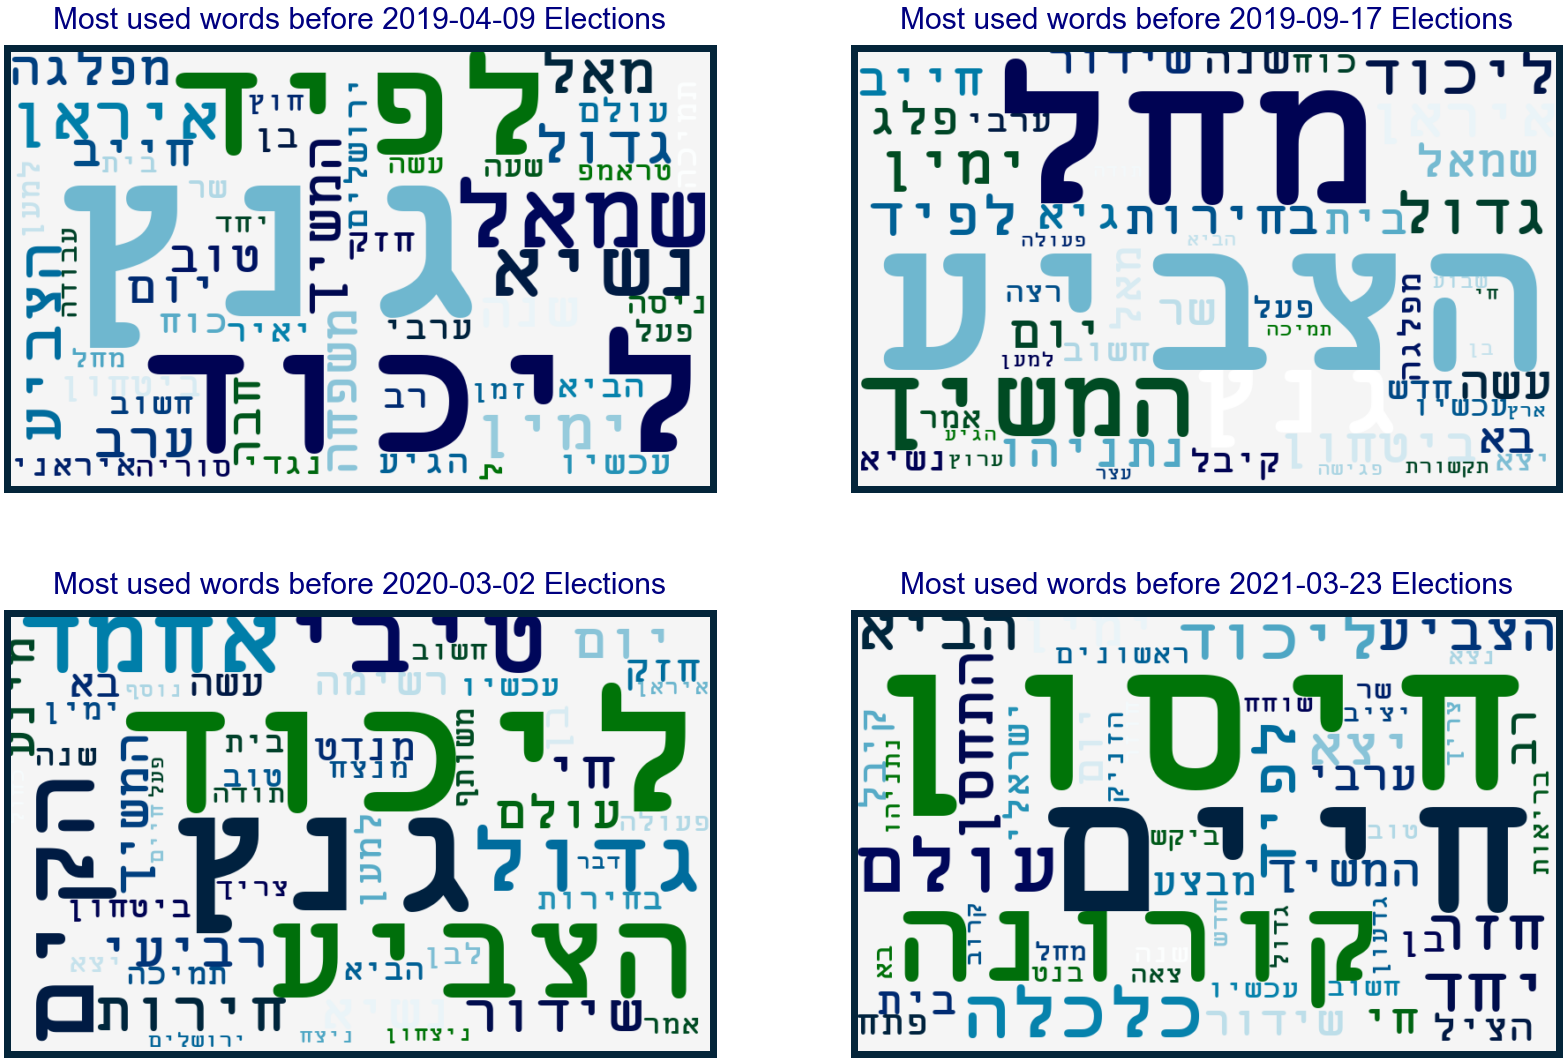

In [12]:
import imageio
fig = plt.figure(figsize=(23,23))

for index, i in enumerate(time_range_b4_elections[1:]):
    temp = " ".join([i for sublist in df_tm.loc[i[0]:i[1],'lemma_text']\
                     for i in sublist if i is not None if i not in words_to_extract])
    ax = fig.add_subplot(3, 2, index+1);
    plt.imshow(word_cloud(temp),interpolation='bilinear')
    for axis in ['top','bottom','left','right']:
        plt.gca().spines[axis].set_color('#04253a')
        plt.gca().spines[axis].set_linewidth(7)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.grid(False)
    plt.tight_layout(h_pad=4, w_pad=4);
    plt.title(f"Most used words before {i[1]} Elections",\
              size=30, color='navy',pad=20);
      

It is clear that the references in the three election campaigns are mostly directed againt the opponents and the importance of voting for the Likud. During the most recent election campaign, it is clear that the tweets are mostly based on achievements in the battle against the Corona virus.

**<u>Training Word2vec</u> with our clean lemmatized Hebrew corpus. Getting the top words for each elections, and use the common words from all 4 elections and their top similar words using cosine similarity.**  

Notes:  
* preprocessing lemmatization was done using stanza (created by the Stanford NLP Group).<br>In Hebrew, stemmer and lemmatizer are complex, mainly because stopwords are prefix and suffix connected with the term itself,  
as a result, word distortions can sometimes be seen after Hebrew lemmatization.
* Again, I  took out words that are repeated most often in the data set, in order to see the words that are more characteristic of each elections campaign. 

In [13]:
df_w2v_b4_elec= df_tm.copy()
flat_words, common_words_set ,word_repetition  = [],[],{}
df_w2v_b4_elec['clean_lemma_text'] = df_w2v_b4_elec['lemma_text']\
              .apply(lambda x: [word for word in x if len(word)>2 if word not in he_s_words if word not in words_to_extract])
doc = df_w2v_b4_elec.clean_lemma_text.tolist()
model = Word2Vec(sentences=doc, size=100, window=5, min_count=1, workers=3)
for index, i in enumerate(time_range_b4_elections[1:]):
    flat_words.append([item for sublist in df_w2v_b4_elec.loc[i[0]:i[1],'clean_lemma_text'] for item in sublist])
    
for i in range(len(flat_words)):
    word_freq = FreqDist(flat_words[i]).most_common(8)
    word_repetition[i] = word_freq
    common_words_set.append([word_freq[i][0] for i in range(len(word_freq))])
terms = set(sum(common_words_set, []))
similiar_words = {search_term: [item[0] for item in model.wv.most_similar(search_term, topn=7)] for search_term in terms}
display(pd.DataFrame(similiar_words).style.hide_index())

הצביע,שמאל,לפיד,איראן,גדול,המשיך,ליכוד,מחל,אחמד,טיבי,כלכלה,הקים,גנץ,קורונה,ימין,חיסון,חיים,עולם,יחד,חירות,נשיא
ימין,גדול,ימין,אפשר,שמאל,יחד,מפלגה,הצביע,גנץ,גנץ,חיים,גדול,הקים,עולם,ליכוד,עולם,קורונה,יום,קורונה,הקים,שוחח
מחל,חייב,הקים,יום,הקים,כוח,ימין,צאה,חירות,חירות,יחד,ליכוד,יאיר,יחד,מפלגה,קורונה,כלכלה,אמר,ביטחון,ליכוד,פגישה
לפיד,ערבי,מפלגה,טרור,חזק,ביטחון,הקים,ימין,הקים,אחמד,עולם,שמאל,שמאל,חיים,הקים,יחד,יחד,חדש,עולם,גדול,חשוב
מאל,חזק,ליכוד,פעל,חייב,למען,גדול,מאל,טיבי,הקים,ראה,גנץ,גדול,נוסף,שמאל,שנה,ישראלי,ראה,המשיך,גנץ,ידיד
צאה,רצה,גנץ,תוכנית,ערבי,עולם,שמאל,לפיד,גדול,לפיד,עשה,מפלגה,ימין,ראה,גדול,יום,עסק,ישראלי,ראה,ימין,ארה״ב
ליכוד,בחירות,שמאל,נוסף,עכשיו,נוסף,חייב,ליכוד,ליכוד,יאיר,בריאות,ימין,ליכוד,חיסון,גנץ,ראה,עולם,הגיע,איש,מפלגה,ערב
מפלגה,הקים,השלה,יהודי,בחירות,פעל,ערבי,מפלגה,יאיר,גדול,קורונה,חירות,מפלגה,הגיע,חייב,נוסף,מקום,מקום,נוסף,שמאל,ירושלים


Despite the fact that this is a small corpus to practice on, words that often appear together in the same way should be semantically associated.  
As a consequence, we can see that similar words are words that Benjamin Netanyahu seeks to relate and link together in his public tweets.  
**Example:** 'Tibi' (Ahmad Tibi is an Arab-Israeli politician) similiar with 'Gantz' and 'Lapid' (former Blue and White party  leaders).

[<a href="#Table-of-Contents:">Back to top</a>]

## 5. Words Timeline Occurrences

I wanted to see how words emerge and change in Benjamin Netanyahu's tweets over time, so I created a function that tests when a word appears in tweets, counts the amount of occurrences, and normalizes them to the number of quarterly tweets in order to determine their relative significance.I narrowed the search to 2015 and later, both because it seems that the popularity of usage (as measured by the number of tweets) has grown since then, and because I wanted to review more specific words and events like elections.

In [14]:
# plt.rcParams.update(plt.rcParamsDefault)
def words_over_time(*argv):
    """
    Return timeline bar plot of normalized words count to quarterly sum of tweets
    """
    temp_df = df['2015':][['tweet']].copy()
    for term in argv:
        temp_df[term] = np.where(temp_df.tweet.str.contains(term),1,0)
    temp_df_q = round((temp_df.resample('Q').sum()/temp_df.resample('Q').count()*100),1).fillna(0)
    temp_df_q.index = temp_df_q.index.strftime('%Y-%m')
    temp_df_q = temp_df_q.T[1:]
    temp_df_q.T.plot(kind='bar',width=0.8, figsize=(18,6), edgecolor='k');
    lgd = [get_display(x) for x in temp_df_q.index]
    plt.legend(lgd,loc='upper left',fontsize=15);ax = plt.axes();
    ax.set_title('Words timeline as a percentage of quarterly tweets', fontsize=20)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter()) 

**Examples:**

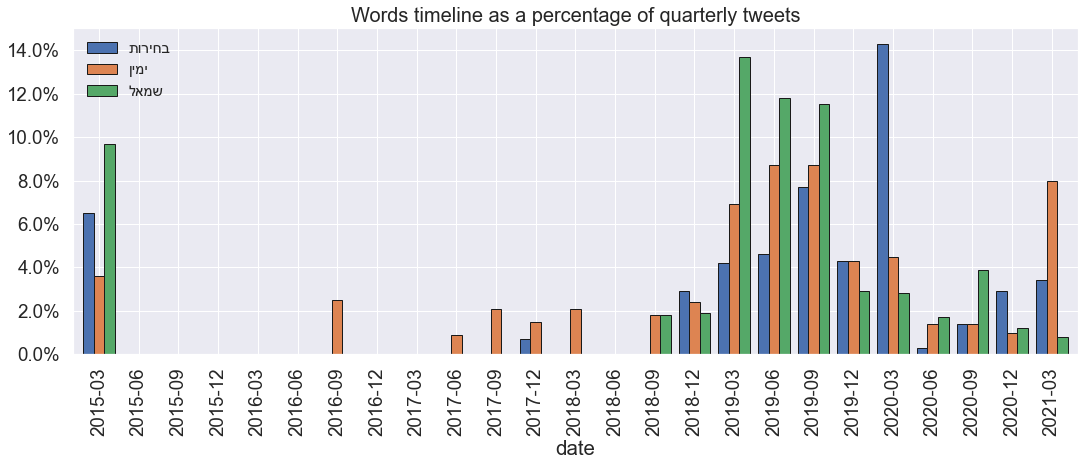

In [15]:
words_over_time('בחירות','שמאל','ימין')

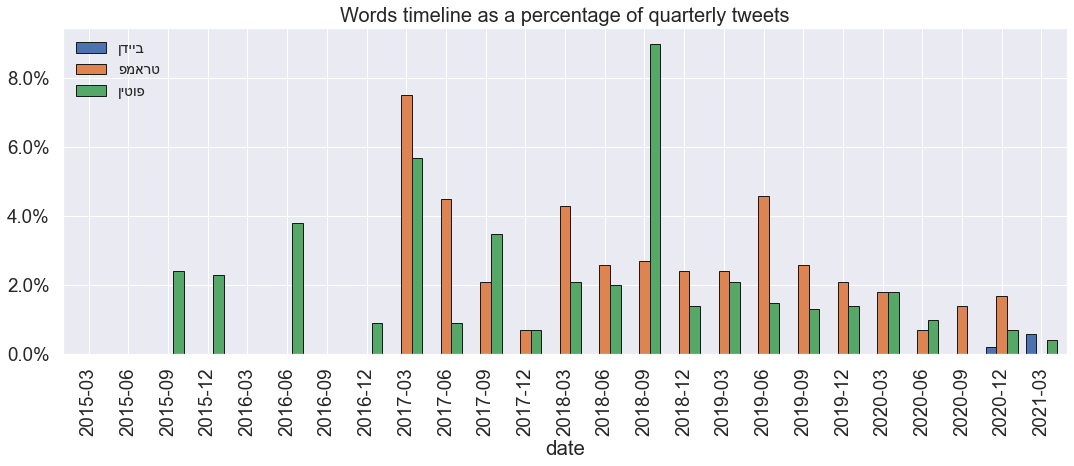

In [16]:
words_over_time('ביידן','טראמפ','פוטין')

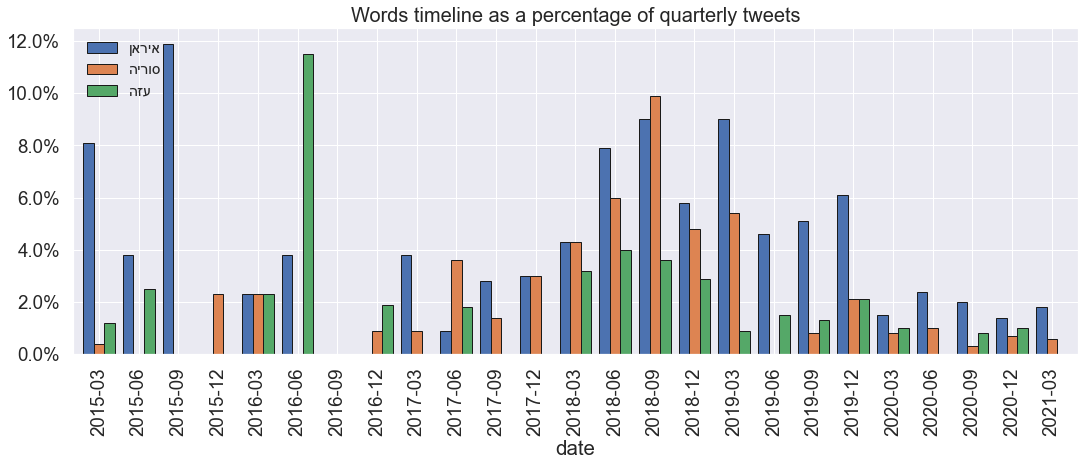

In [17]:
words_over_time('איראן','סוריה','עזה')

[<a href="#Table-of-Contents:">Back to top</a>]

## 6. Sentiment Analysis with HeBERT   

HeBERT is a Hebrew pretrained language model. It is based on Google's BERT architecture and it is BERT-Base config **[Link](https://github.com/avichaychriqui/HeBERT)

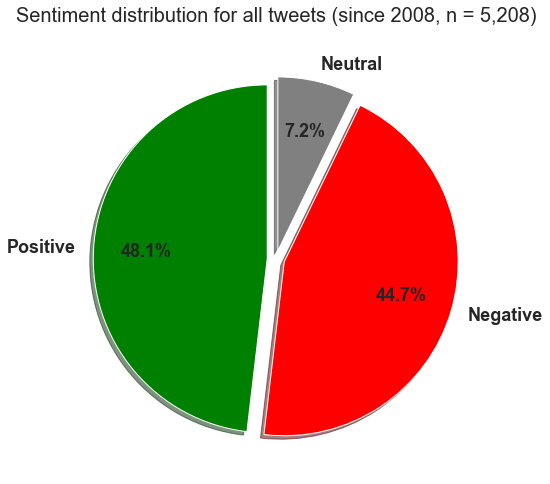

In [18]:
# Load the dataset
df_heBert = pd.read_pickle('df_heBert.pkl')
df_since2019 = df_heBert['2019':].groupby('s_heBert_label').resample('M').size().T

sentiment_dist_plot(df_heBert)

**On the whole, there is a balanced positive/negative sentiment ratio among tweets.**

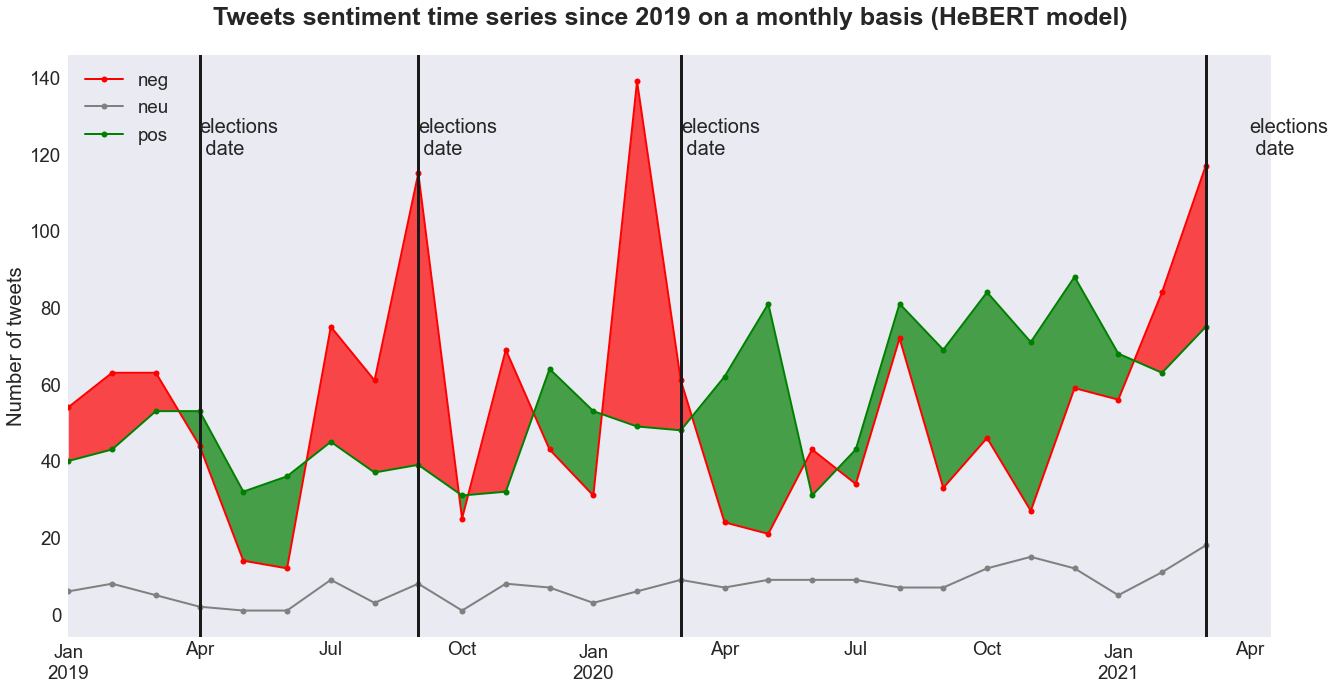

In [19]:
# Monthly since 2019
sentiment_m_time(df_heBert)

**We can observe the relationship between election days and the spike in negative sentiment tweets before them,  
along with an increase in tweet frequency as I have shown previously.**  
* Note: negative sentiment refers to a wide range of emotions that are expressed in the text, including rage, fear, urgency, concern, and more.<br>It seems that negative sentiment tweets might be useful in provoking voters to act.

**We need to quantify the difference in sentiment before and after the general elections.  
For this, we will examine the distribution 90 days before each elections date, and 90 days afterward (including 2015 elections).**

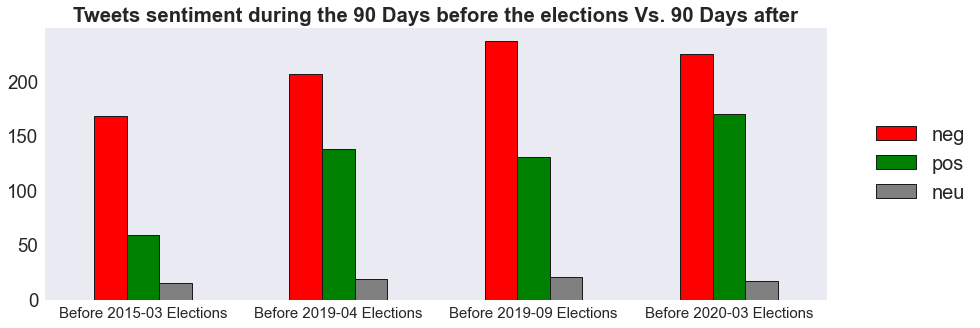

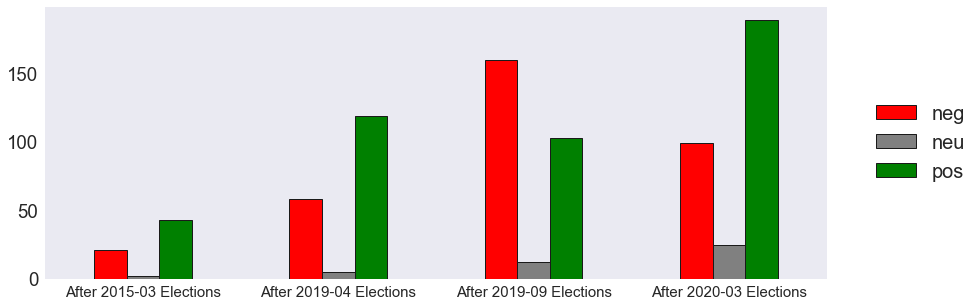

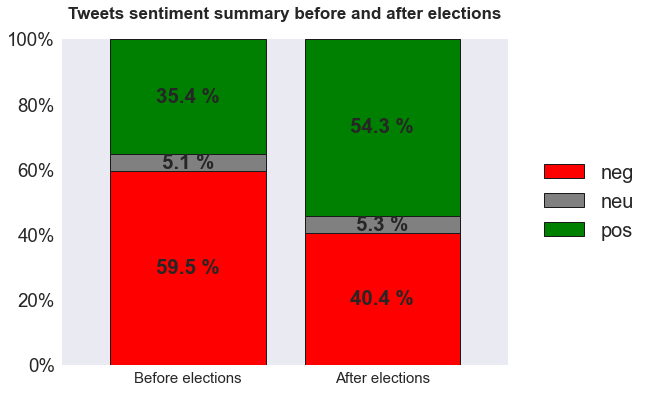

In [20]:
sentiment_days(df_heBert,election_dates, n=90)

[<a href="#Table-of-Contents:">Back to top</a>]

## 7. Topic Modeling

Topic Modeling aims to find the topics (or clusters) inside a corpus of texts, without knowing those topics at first. It's an unsupervised classification technique.
I'll be using for this task:

#### Gibbs sampling algorithm for a Dirichlet Mixture Model

* Model-based clustering method for short texts.The algorithm iterating across and reassigning clusters using a conditional distribution as a basis. Documents are allocated to clusters based on the highest conditional probability, similar to how the Naive Bayes Classifier functions. It assumes that each short text is generated from single latent topic and use Gibbs sampling technique. The model claims to overcome the short text clustering sparsity problem while still displaying word topics like LDA. 

In [21]:
# Eliminate top words and words below 3 characters to try to help the algorithm refine the clustering.
df_tm['clean_lemma_text'] = df_tm['lemma_text']\
                            .apply(lambda x: [word for word in x if word not in words_to_extract and len(word)>2])

In [22]:
docs = df_tm['clean_lemma_text'].tolist()

np.random.seed(10) 
# GSDMM algorithm
mgp = MovieGroupProcess(K=10, alpha=0.1, beta=0.1, n_iters=10)

vocab = set(x for doc in docs for x in doc)
n_terms = len(vocab)
n_docs = len(docs)

# Fit the model
y = mgp.fit(docs, n_terms)

In stage 0: transferred 3761 clusters with 10 clusters populated
In stage 1: transferred 2209 clusters with 10 clusters populated
In stage 2: transferred 1343 clusters with 10 clusters populated
In stage 3: transferred 910 clusters with 10 clusters populated
In stage 4: transferred 732 clusters with 10 clusters populated
In stage 5: transferred 639 clusters with 10 clusters populated
In stage 6: transferred 587 clusters with 10 clusters populated
In stage 7: transferred 491 clusters with 10 clusters populated
In stage 8: transferred 449 clusters with 10 clusters populated
In stage 9: transferred 466 clusters with 10 clusters populated


In [23]:
def top_words(distribution, top_index, num_words):
    '''
    Returns the top words in each cluster based on occources.
    '''
    for topic in top_index:
        pairs = sorted([(k, v) for k, v in distribution[topic].items()], key=lambda x: x[1], reverse=True)
        print(f"Cluster {topic} : {pairs[:num_words]}")
        print('-'*120)

In [24]:
doc_count = np.array(mgp.cluster_doc_count)
print('Number of documents per topics :', doc_count)
print('*'*70)

# Topics sorted by document inside
top_index = doc_count.argsort()[-15:][::-1]
print('Most important clusters (by number of docs inside):', top_index)
print('*'*70)


# Show the top 15 words by cluster, it helps to make the topic_dict below
top_words(mgp.cluster_word_distribution, top_index, 15)

Number of documents per topics : [420 481 446 428 540 842 601 349 291 321]
**********************************************************************
Most important clusters (by number of docs inside): [5 6 4 1 2 3 0 7 9 8]
**********************************************************************
Cluster 5 : [('שלום', 239), ('קורונה', 239), ('חיסון', 192), ('עולם', 167), ('חיים', 166), ('המשיך', 154), ('כלכלה', 138), ('יחד', 133), ('הביא', 119), ('יום', 102), ('בריאות', 99), ('עסק', 97), ('קיבל', 90), ('שנה', 89), ('עשה', 88)]
------------------------------------------------------------------------------------------------------------------------
Cluster 6 : [('נשיא', 190), ('איראן', 101), ('חשוב', 86), ('טראמפ', 83), ('נתניהו', 79), ('פגישה', 72), ('פוטין', 70), ('אמריקני', 58), ('רוסיה', 57), ('שלום', 53), ('יום', 52), ('ארה"ב', 52), ('שידור', 51), ('עולם', 49), ('אמר', 46)]
----------------------------------------------------------------------------------------------------------------------

In [25]:
# created by hand so that the topic names refer to the above clusters
topic_dict = {}
topic_names = ['Health & Economy',
               'International Affairs',
               'International Affairs',
               'National Security',
               'Politics',
               'Memorials',
               'Politics',
               'Politics',
               'State security',
               'personal allegations']

for i, topic_num in enumerate(top_index):
    topic_dict[topic_num]=topic_names[i]

**The most reliable method for evaluating unsupervised topic models is still human judgement. However, this takes time and money. I had to look at a few randomly picked tweets in each cluster, much as I had to do with the topic names. 
The results are not perfect, and there might be ways to improve, but as compared to other teqniuqes I tired, GSDMM produced the best results.**

In [26]:
# assign clusters into the dataframe 
df_tm['cluster_name'] = pd.Series([topic_dict[int(x)] for x in y], index=df_tm.index)
df_tm['cluster_number'] = pd.Series(y, index=df_tm.index)
df_tm['cluster_name'].value_counts()
c = df_tm['cluster_name'].value_counts()
p = np.round(df_tm['cluster_name'].value_counts(normalize=True)*100,1)
pd.concat([c,p], axis=1, keys=['counts', '%'])

,counts,%
Politics,1215,25.7
International Affairs,1141,24.2
Health & Economy,842,17.8
National Security,481,10.2
Memorials,428,9.1
State security,321,6.8
personal allegations,291,6.2


**Politics, along with international relations, are the most common issues (50%) on which Benjamin Netanyahu tweets about.**

In [27]:
print('Top words related to politics:')
top_words(mgp.cluster_word_distribution, [0,2,7], 7)

Top words related to politics:
Cluster 0 : [('ליכוד', 101), ('שנה', 55), ('למען', 54), ('תמיכה', 49), ('טוב', 46), ('המשיך', 44), ('תפקיד', 42)]
------------------------------------------------------------------------------------------------------------------------
Cluster 2 : [('הצביע', 205), ('ליכוד', 192), ('לפיד', 119), ('ימין', 115), ('מחל', 92), ('גנץ', 88), ('שמאל', 68)]
------------------------------------------------------------------------------------------------------------------------
Cluster 7 : [('גנץ', 112), ('טיבי', 55), ('ליכוד', 51), ('אחמד', 50), ('הקים', 48), ('שידור', 36), ('חירות', 36)]
------------------------------------------------------------------------------------------------------------------------


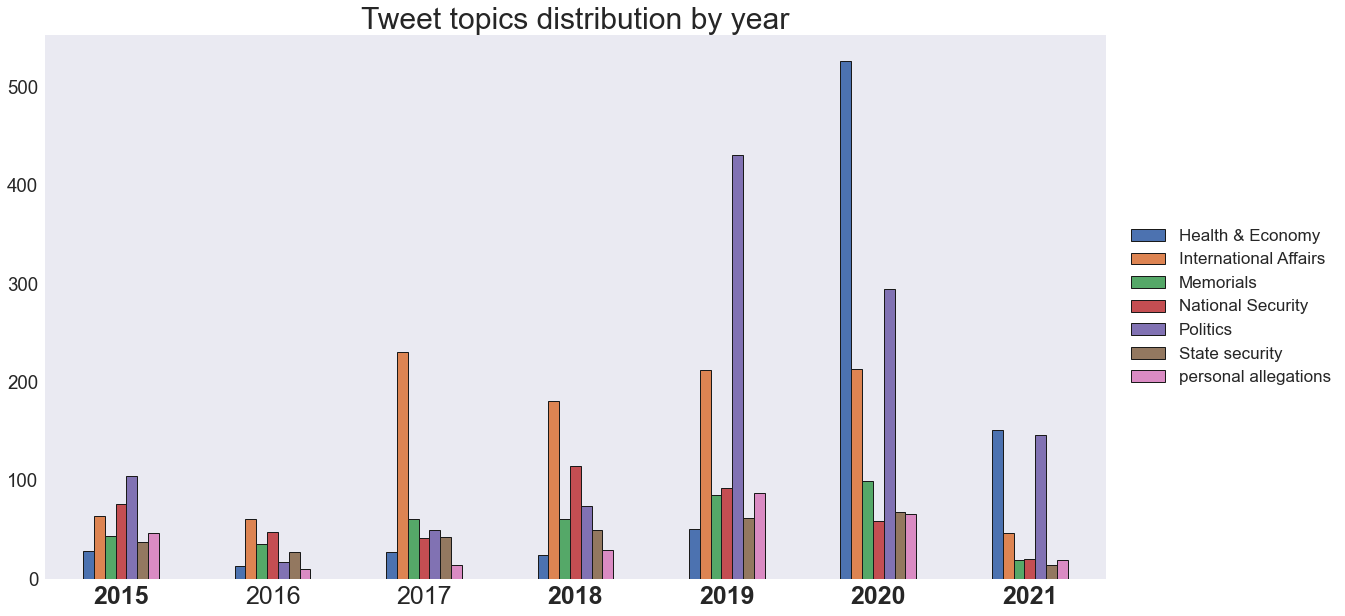

In [28]:
df_gsdmm = df_tm['2015':].resample('Y').cluster_name.value_counts().unstack().fillna(0)
df_gsdmm.index = df_gsdmm.index.strftime('%Y')
df_gsdmm.plot(kind='bar',figsize=(19,10), edgecolor='k');
plt.title(f'Tweet topics distribution by year', size=30);plt.xlabel("")
plt.legend(bbox_to_anchor=(1.01,0.5), loc="center left",prop={'size': 17});plt.xticks(size=25,rotation=0);
[plt.gca().get_xticklabels()[i].set_fontweight('bold') for i in [0,3,4,5,6]];

**As can be seen in <u>election years</u>, the number of tweets about politics is incredibly high.  
It can also be seen that by 2020, the majority of tweets were in the health sector as a result of the <u>Corona plague</u>.**

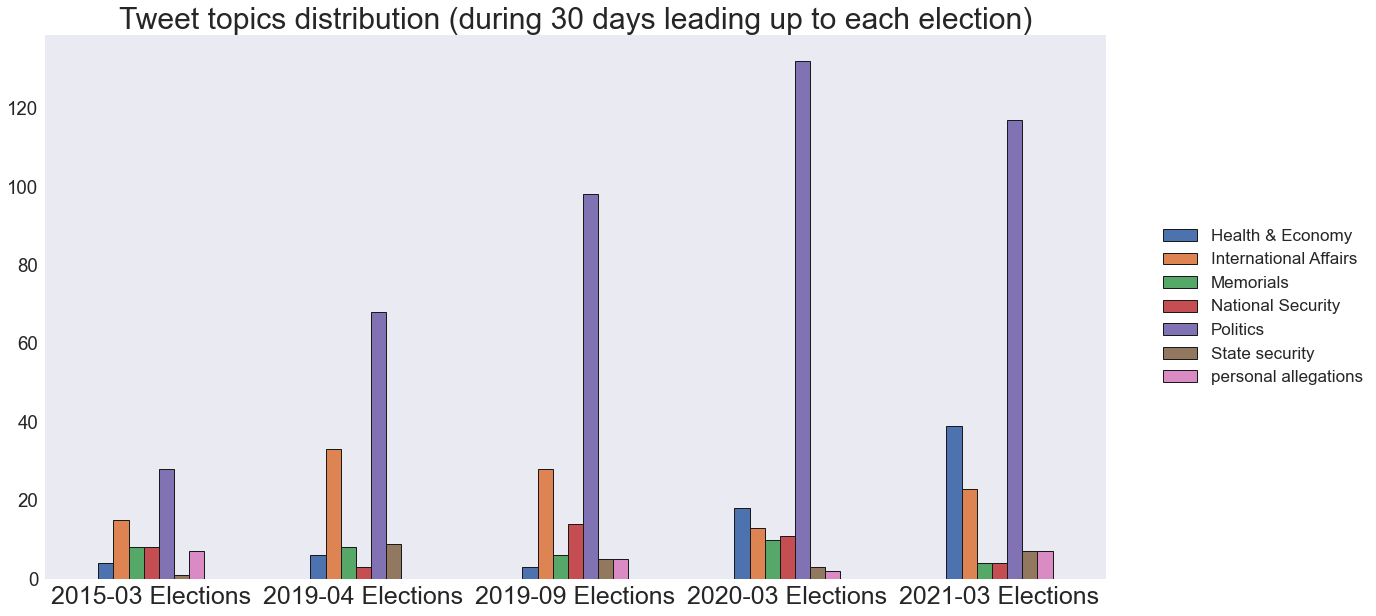

In [29]:
d = dict()
one_month_bfore_election =[str(dt.datetime.fromisoformat(i).date() - dt.timedelta(days=30)) for i in election_dates]
time_range_b4_elections_1m = list(zip(one_month_bfore_election,election_dates))

for i, index in enumerate(time_range_b4_elections_1m):
    d[f'{index[1][:-3]} Elections'] = df_tm.loc[time_range_b4_elections_1m[i][0]:time_range_b4_elections_1m[i][1]]\
    .groupby('cluster_name')[['cluster_name']].count()

df_gsdmm_1m = pd.concat(d, axis=1).fillna(0).T
df_gsdmm_1m.reset_index(level=1, drop=True, inplace=True)
df_gsdmm_1m.plot(kind='bar',figsize=(19,10), edgecolor='k');
plt.title(f'Tweet topics distribution (during 30 days leading up to each election)', size=30);plt.xlabel("")
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left",prop={'size': 17});plt.xticks(size=25,rotation=0);

**As one would expect, during the thirty days before each election,<br>
the tweets are almost entirely dedicated to dealing with the general election.**

[<a href="#Table-of-Contents:">Back to top</a>]

## 8. Topics & Sentiment

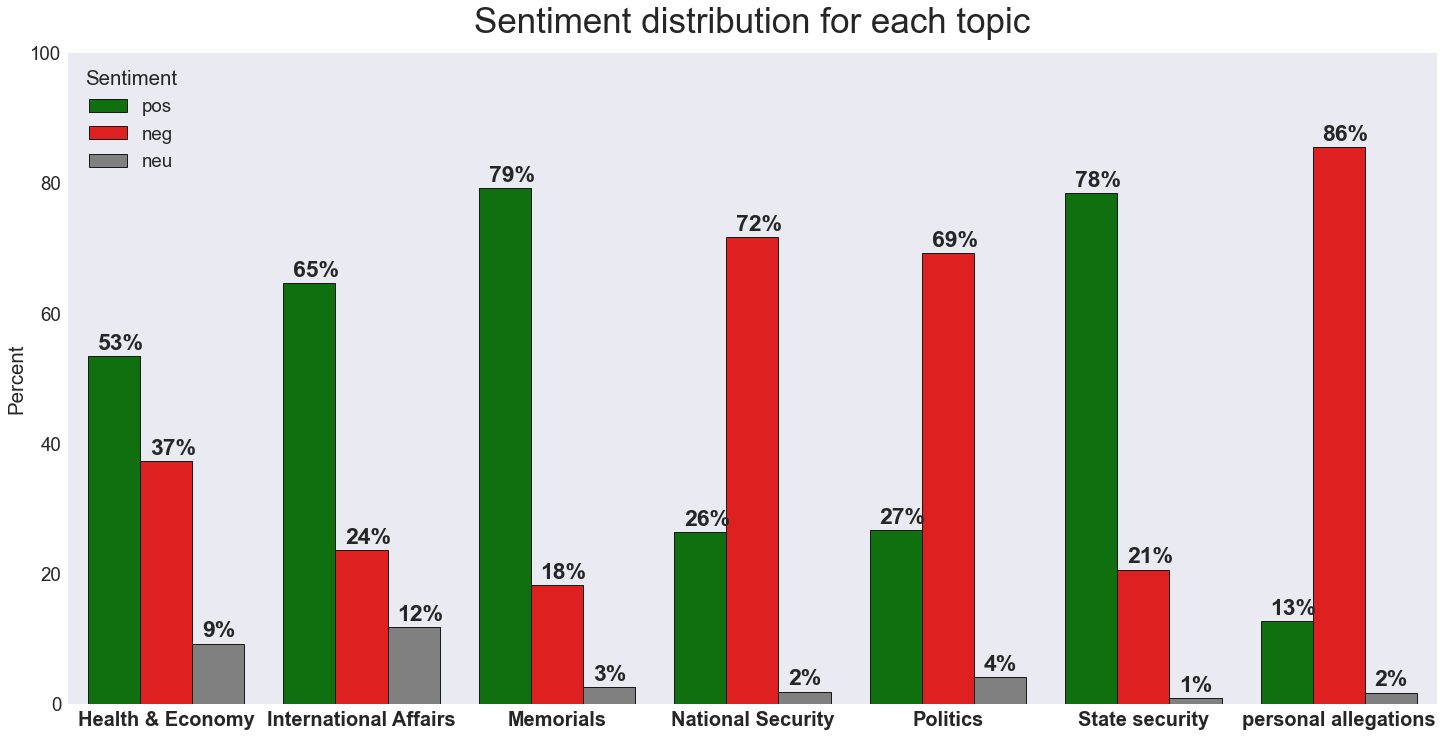

In [30]:
df_merged = pd.merge(df_tm, df_heBert[['tweet','s_heBert_label']], on=['tweet']).set_index('date')
df_topic_sent = df_merged.groupby('cluster_name')['s_heBert_label'].value_counts(normalize=True)*100
df_topic_sent = df_topic_sent.rename('Percent').reset_index()
g = sns.catplot(x='cluster_name',y='Percent',hue='s_heBert_label',kind='bar',data=df_topic_sent, height=10, aspect=2,
               palette ={"pos": "green", "neu": "grey", "neg": "red"}, edgecolor='k',legend_out = False);
g.ax.set_ylim(0,100);g._legend.set_title('Sentiment');g.set(xlabel=None);g.set_xticklabels(size=20, fontweight='bold');
plt.title('Sentiment distribution for each topic',size=35, pad=20);
for p in g.ax.patches:
    txt = str(round(p.get_height())) + '%'
    txt_x, txt_y = p.get_x(), p.get_height()
    g.ax.text(txt_x+0.05,txt_y+1,txt,fontweight='semibold', fontsize=23)

* It's clear that tweets about National Security, Politics, and Personal allegations are strongly associated with negative sentiment.

Let's see for example how tweets with the negative sentiment, in the politics cluster, are actually expressed **before elections**.<br>To do so, I combined data from the month before each election into a single data set and filtered it by cluster (**politics**) and sentiment (**negative**):

In [31]:
df_ets= pd.DataFrame()
for i in range(len(time_range_b4_elections_1m)):    
    df_ets = df_ets.append(df_merged.loc[time_range_b4_elections_1m[i][0]:time_range_b4_elections_1m[i][1],
                           ['cluster_name','clean_tweet','s_heBert_label']])

df_ets = df_ets.loc[(df_ets['cluster_name'] == 'Politics') & (df_ets['s_heBert_label'] == 'neg')]
pd.set_option('display.max_colwidth', None)
df_ets.sample(7, random_state=4)['clean_tweet'].to_frame()

,clean_tweet
date,
2021-03-20,בובוטציה אסור לתת יד לממשלת רוטוציה מסוכנת שתפגע בכלכלה עוד מנדטים ואנחנו מביאים ניצחון ענק לליכוד וממשלת ימין יציבה שתזניק את הכלכלה
2019-09-16,עמית סגל ״מצביעי הליכוד לא מגיעים לקלפי יש התעוררות בקרב השמאל״ אם לא תצאו להצביע מחל הימין יפסיד ונקבל ממשלת שמאל עם המפלגות הערביות צאו להצביע
2019-03-30,עלילת הדם של לפיד וגנץ התרסקה לרסיסים
2015-03-11,רק הצבעה לליכוד תמנע ממשלת שמאל
2020-02-20,אמרנו לכם לגנץ אין ממשלה בלי אחמד טיבי רק ליכוד גדול יעצור את זה
2021-03-23,דיווח חירום אחוזי הצבעה נמוכים מאוד לליכוד בערים הבאות ירושלים ראשל״צ פתחתקווה נתניה אשדוד אשקלון עכו קרית גת קרית אתא רחובות לוד רמלה ונהריה צאו להצביע מחל
2019-04-09,מצביעי הימין צאו להצביע לליכוד עכשיו


**As can be seen, the negative tweets before elections (at least from this random sampling) communicate urgency and intimidation,  
which is followed by imperative phrases (commanding people to vote for Likud party).**

[<a href="#Table-of-Contents:">Back to top</a>]

## 9. Conclusion

**Since 2015, Benjamin Netanyahu has become more involved on Twitter.  
His Twitter activity tends to rise dramatically before each elections day, and usually drops afterward.  
Half of his tweets are about politics and foreign affairs.  
On the run-up to each elections, nearly all tweets are devoted to politics,  
and have bearing a negative sentiment with imperative phrases, that are intended to encourage people to vote.**


